# EasyTS Tutorial - increasing the knot resolution

**Author:** Hannu Parviainen <br>
**Edited:** 14 August 2024

The resolution of the transmission spectrum estimated by EasyTS depends on two factors: 
1. the intrinsic spectroscopic resolution of the data, and
2. the number and locations of the radius ratio spline knots.
   
While both can be modified before starting a new analysis, EasyTS also makes it extremely easy to start from a lower-resolution result. Here, we see how to create a new analysis using the saved results from Tutorial 1, add radius ratio knots to the model, and estimate the transmission spectrum with this more complex model. Of course, nothing stops you from completely changing the radius ratio knot setup. 

The next tutorial shows how to continue from Tutorial 1 results but use the full intrinsic resolution of the JWST data set without binning.

In [1]:
%run ../setup_multiprocessing.py

In [2]:
%matplotlib inline

In [3]:
from multiprocessing import Pool
from numpy import linspace
from easyts.easyts import read_model, clean_knots

## Read in the Tutorial 1 result

First, we recreate the model in Tutorial 1 using the `easyts.read_model` function. The function takes the name of the save file, and, optionally, a new model name. If a new name isn't given, the original name is used.

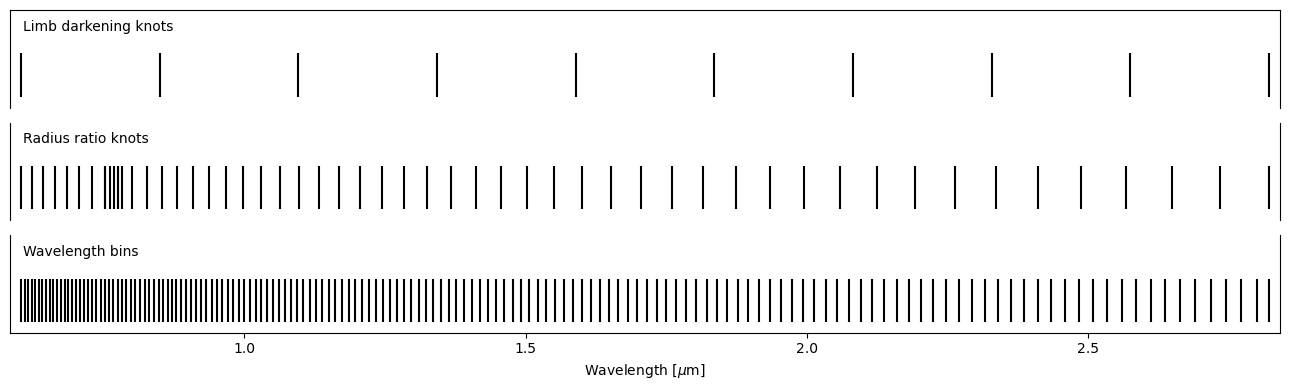

In [4]:
ts = read_model("01a_lowres_power2.fits", name='02a')
ts.plot_setup();

In [5]:
pargs = dict(figsize=(13,7), res_args=dict(pmin=5, pmax=95), 
             trs_args=dict(xscale='log', ylim=(2.06, 2.19), xticks=[0.6, 0.88, 1.16, 1.44, 1.72, 2.0, 2.30, 2.8]))

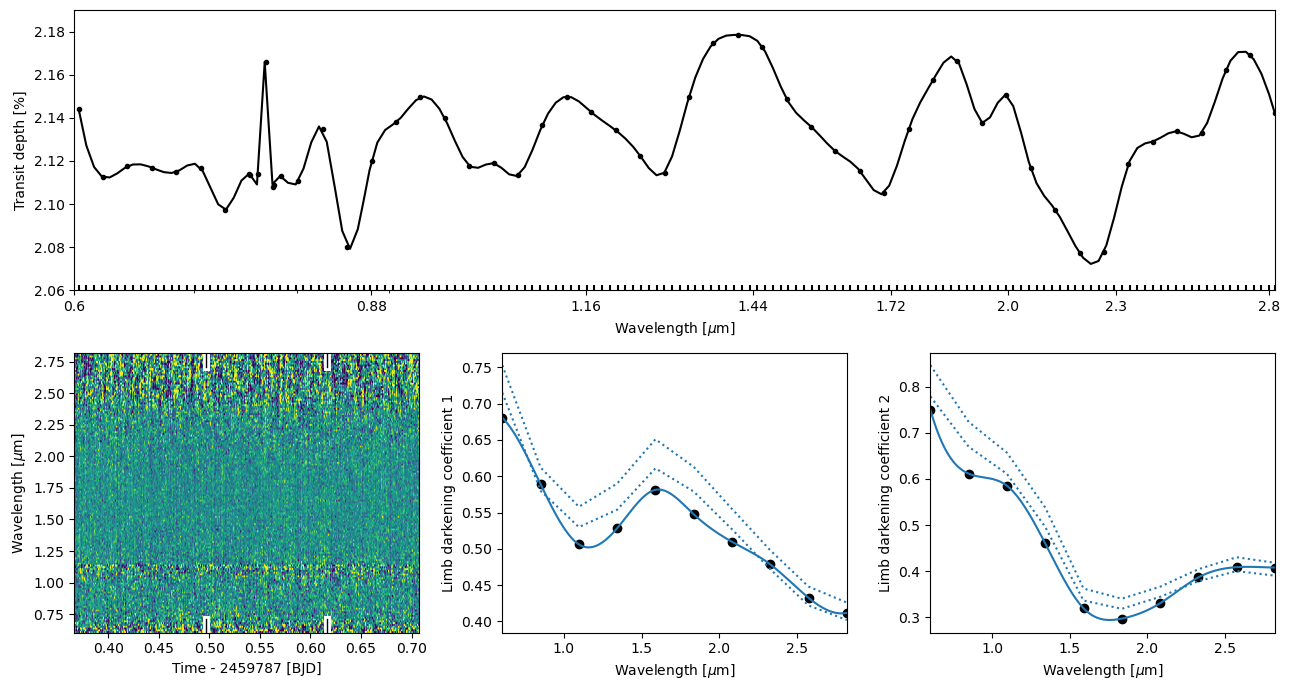

In [6]:
ts.plot_fit(result='fit', **pargs)

## Change the radius ratio knots

Next, we change the radius ratio knots. Let's just increase the knot resolution locally between 1.5 - 1.35 $\mu$m.

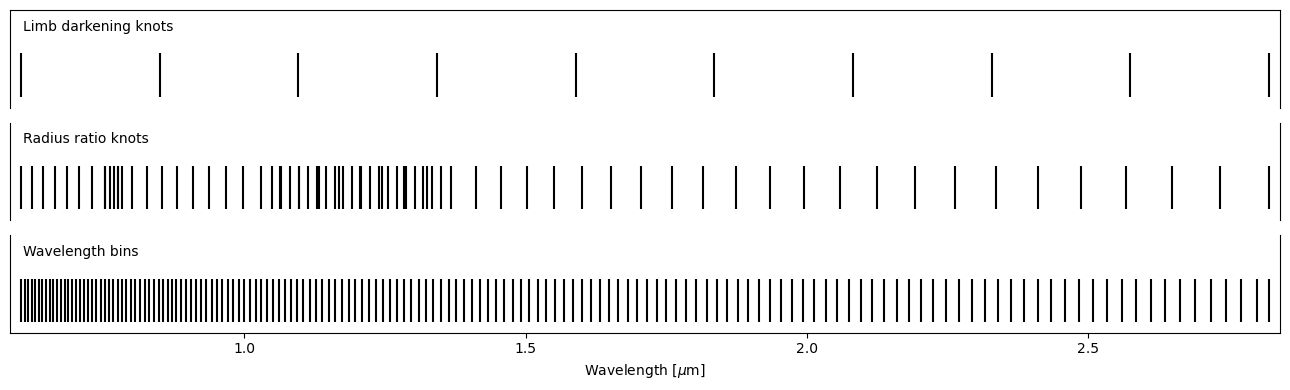

In [7]:
ts.add_radius_ratio_knots(linspace(1.05, 1.35, 20))
fig = ts.plot_setup();

Now, we ended up with some knots located very near to each other. This is not something we want (well, here, at least), so we can use the `easyts.clean_knots` utility function to replace groups of knots with too small distances by single knots located at the group means.

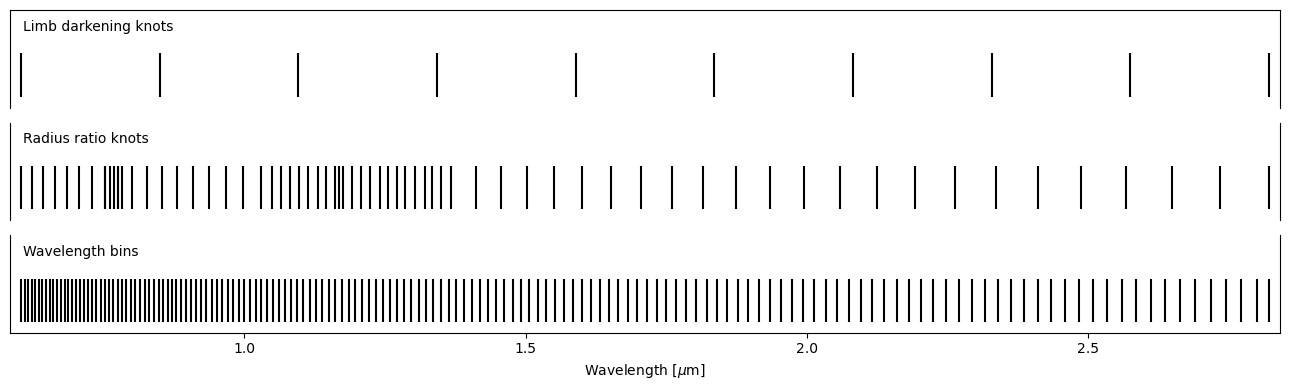

In [8]:
ts.set_radius_ratio_knots(clean_knots(ts.k_knots, 0.0075, lmin=1.0))
ts.plot_setup();

## Refit the model

In [10]:
ts.reset_sampler()
ts.add_noise_to_solution('fit')

In [9]:
def lnpostf(pv):
    return ts.lnposterior(pv)

pool = Pool(8)

Global optimisation:   0%|          | 0/1000 [00:00<?, ?it/s]

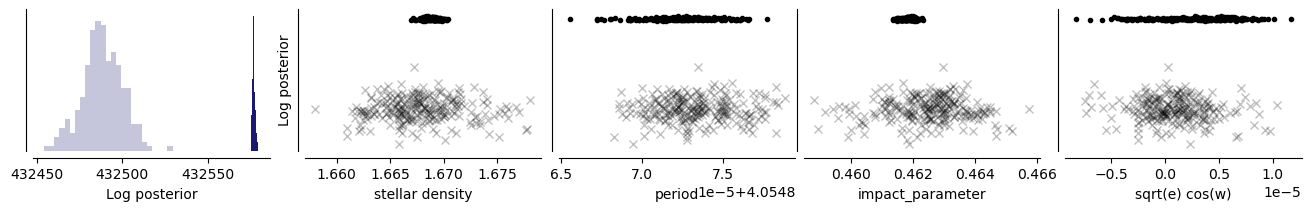

In [18]:
ts.fit(niter=1000, npop=250, pool=pool, lnpost=lnpostf)

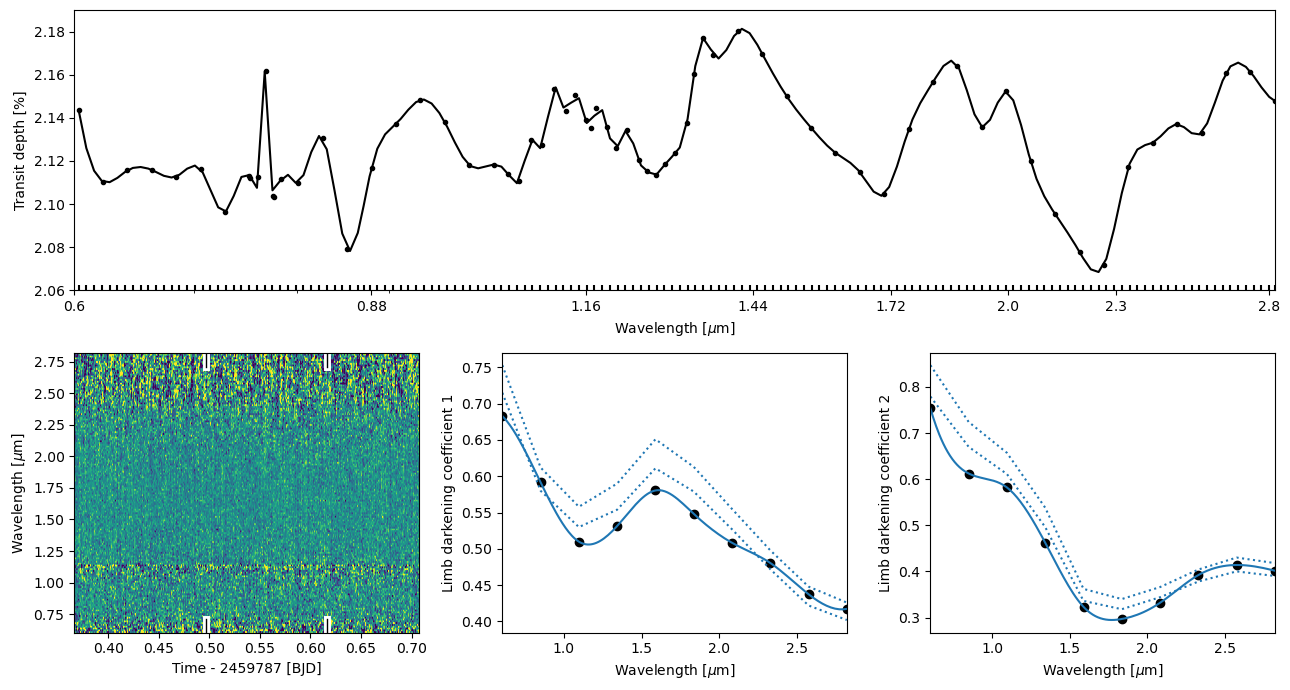

In [19]:
ts.plot_fit(result='fit', **pargs)

## Sample the posterior

Finally, we can continue from the Tutorial 1 solution.  

In [23]:
ts.sample(1000, thin=10, repeats=3, pool=pool, lnpost=lnpostf)

MCMC sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Run 1/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 2/3:   0%|          | 0/1000 [00:00<?, ?it/s]

Run 3/3:   0%|          | 0/1000 [00:00<?, ?it/s]

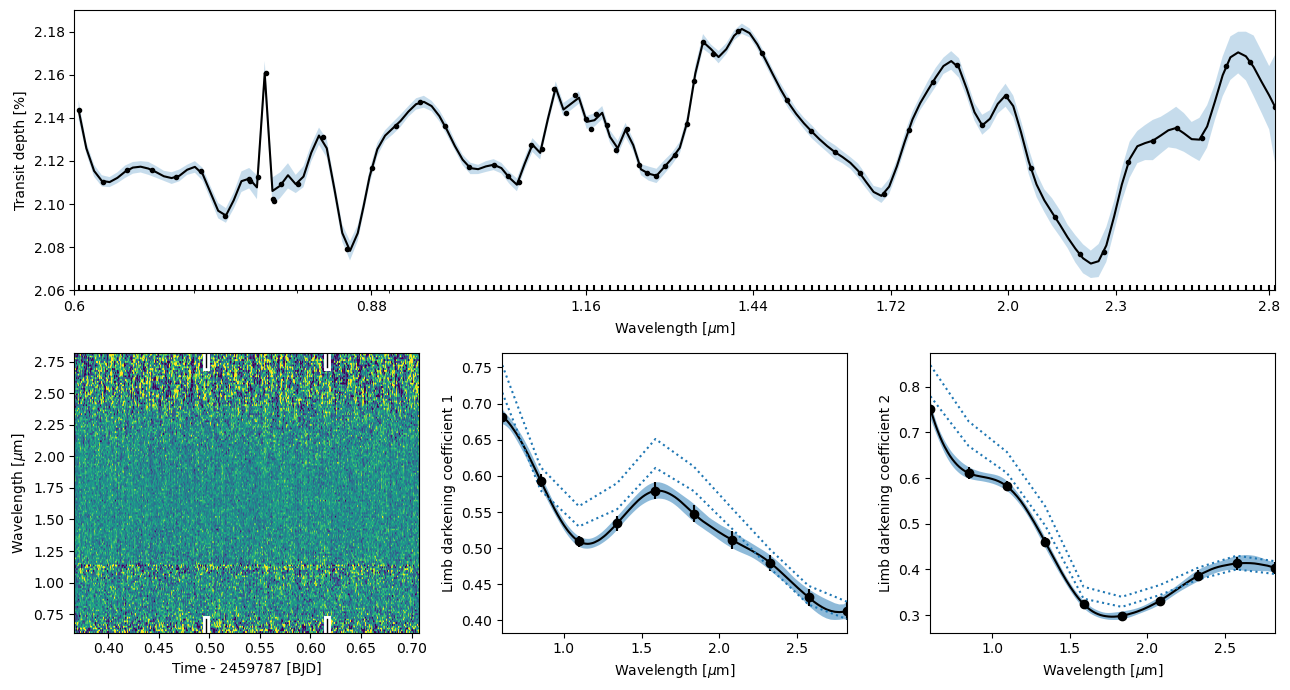

In [24]:
ts.plot_fit(result='mcmc', **pargs)

---

<center>&copy;2024 Hannu Parviainen</center>